In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# Preprocessing

In [2]:
df = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv',index_col='ObservationDate',parse_dates=True)
covidIndia = df[df['Country/Region'] == 'India']
covidIndia.drop(['SNo','Last Update','Province/State'],axis=1,inplace = True)
covidIndia.head()

,Country/Region,Confirmed,Deaths,Recovered
ObservationDate,,,,
2020-01-30,India,1.0,0.0,0.0
2020-01-31,India,1.0,0.0,0.0
2020-02-01,India,1.0,0.0,0.0
2020-02-02,India,2.0,0.0,0.0
2020-02-03,India,3.0,0.0,0.0


In [3]:
covidIndia.tail()

,Country/Region,Confirmed,Deaths,Recovered
ObservationDate,,,,
2020-04-27,India,29451.0,939.0,7137.0
2020-04-28,India,31324.0,1008.0,7747.0
2020-04-29,India,33062.0,1079.0,8437.0
2020-04-30,India,34863.0,1154.0,9068.0
2020-05-01,India,37257.0,1223.0,10007.0


In [4]:
print("Shape of Data is ==> ",covidIndia.shape)

Shape of Data is ==>  (93, 4)


In [5]:
covidIndia.index[:10]

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08'],
              dtype='datetime64[ns]', name='ObservationDate', freq=None)

In [6]:
covidIndia.index.freq = 'D'
covidIndia.index[:10]

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08'],
              dtype='datetime64[ns]', name='ObservationDate', freq='D')

> I have checked Index to set frequency of Time Series data. It is important to set frequency of Time Series data to avoid unnecessary errors in statsmodels.

# ETS Decomposition

The <a href='https://en.wikipedia.org/wiki/Decomposition_of_time_series'>decomposition</a> of a time series attempts to isolate individual components such as <em>error</em>, <em>trend</em>, and <em>seasonality</em> (ETS).

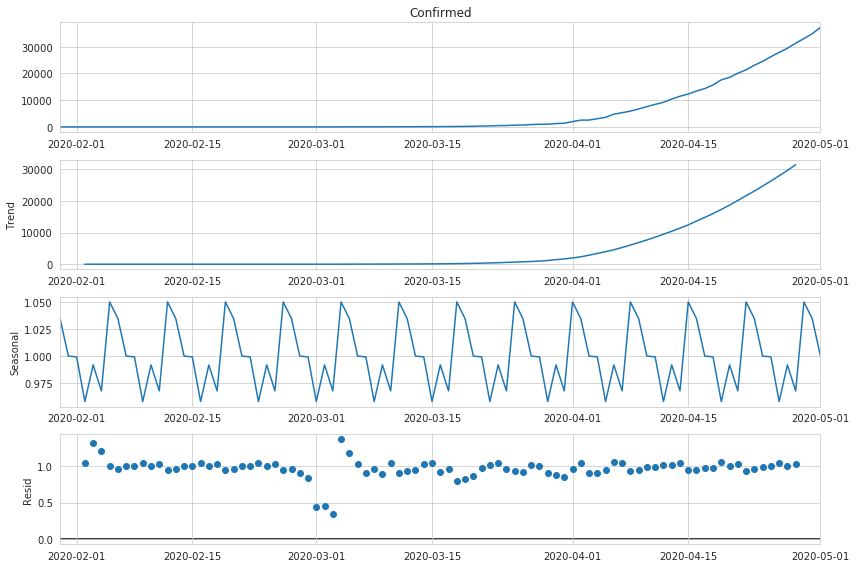

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(covidIndia['Confirmed'], model='mul')

from pylab import rcParams
rcParams['figure.figsize'] = 12,8
result.plot();

> I will be using Multiplicative model because trend is not linear , It is exponential. Also i will not be using seasonality because it looks like there is no seasonal pattern.

# Holt Winters Method

### <font color=blue>Simple Exponential Smoothing / Simple Moving Average</font>
This is the simplest to forecast. $\hat{y}$ is equal to the most recent value in the dataset, and the forecast plot is simply a horizontal line extending from the most recent value.
### <font color=blue>Double Exponential Smoothing / Holt's Method</font>
This model takes trend into account. Here the forecast plot is still a straight line extending from the most recent value, but it has slope.
### <font color=blue>Triple Exponential Smoothing / Holt-Winters Method</font>
This model has (so far) the "best" looking forecast plot, as it takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

In [9]:
train_data = covidIndia.iloc[:78]
test_data = covidIndia.iloc[78:]

from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Confirmed'],trend='mul').fit()

test_predictions = fitted_model.forecast(15).rename('Confirmed Forecast')

In [10]:
print("Prediction ==> \n",test_predictions[:5])
print("\n","Actual Data ==> \n",test_data[:5]['Confirmed'])

Prediction ==> 
 2020-04-17    14683.312115
2020-04-18    16034.903967
2020-04-19    17510.909203
2020-04-20    19122.780013
2020-04-21    20883.022761
Freq: D, Name: Confirmed Forecast, dtype: float64

 Actual Data ==> 
 ObservationDate
2020-04-17    14352.0
2020-04-18    15722.0
2020-04-19    17615.0
2020-04-20    18539.0
2020-04-21    20080.0
Freq: D, Name: Confirmed, dtype: float64


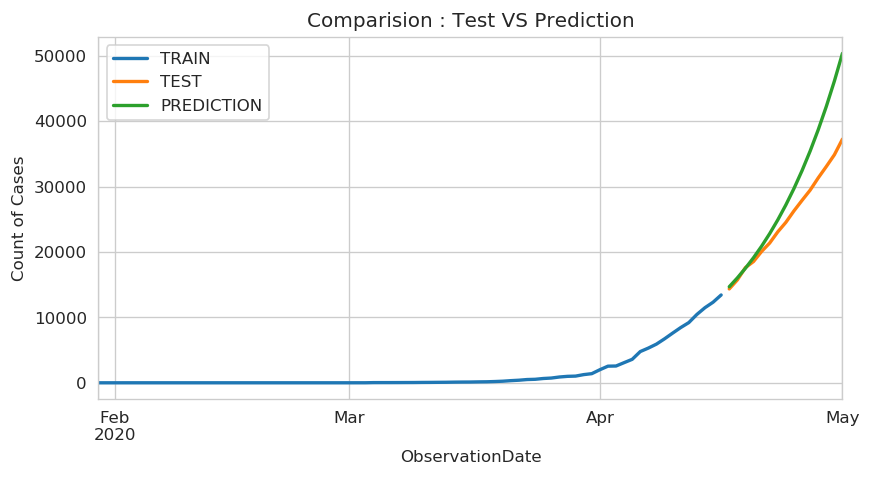

In [11]:
fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Count of Cases',title = 'Comparision : Test VS Prediction')
train_data['Confirmed'].plot(legend=True,label='TRAIN',lw = 2)
test_data['Confirmed'].plot(legend=True,label='TEST',figsize=(8,4),lw = 2)
test_predictions.plot(legend=True,label='PREDICTION',lw = 2);

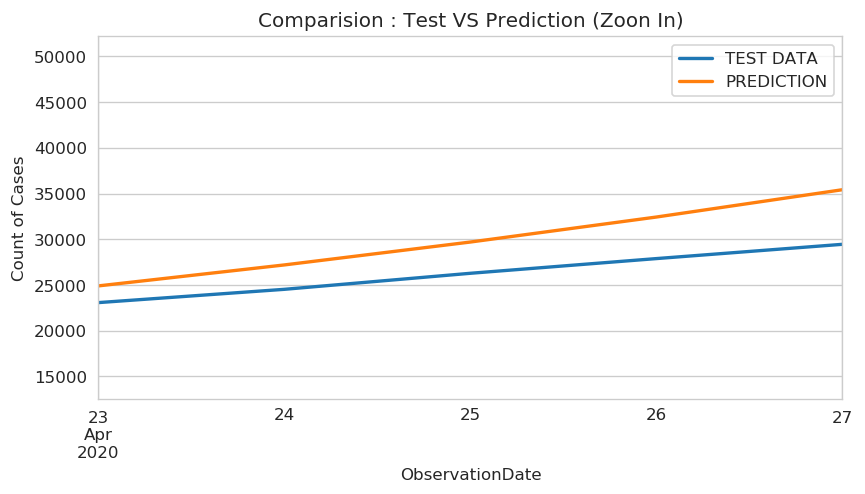

In [13]:
fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Count of Cases',title = 'Comparision : Test VS Prediction (Zoon In)')
test_data['Confirmed'].plot(legend=True,label='TEST DATA',figsize=(8,4),lw = 2)
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2020-04-23','2020-04-27'],lw = 2);

In [14]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

print("MAE ==> ",mean_absolute_error(test_data['Confirmed'],test_predictions))
print("MSE ==> ",mean_squared_error(test_data['Confirmed'],test_predictions))
print("RMSE ==> ",np.sqrt(mean_squared_error(test_data['Confirmed'],test_predictions)))

MAE ==>  4194.322799583712
MSE ==>  34603322.864679076
RMSE ==>  5882.458913131402


In [16]:
test_data.describe()['Confirmed']['std']

7168.11296812554

## Forecasting using Holt Method

In [17]:
final_model = ExponentialSmoothing(train_data['Confirmed'],trend='mul').fit()
forecast_predictions = final_model.forecast(30)

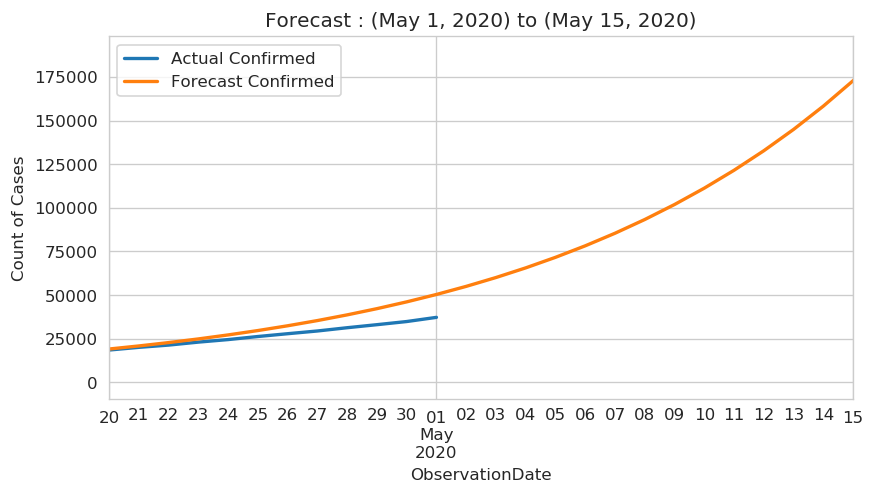

In [18]:
fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Count of Cases',title = 'Forecast : (May 1, 2020) to (May 15, 2020)')
covidIndia['Confirmed'].plot(figsize=(8,4),lw = 2,legend = True,label = 'Actual Confirmed')
forecast_predictions.plot(lw=2,legend = True,label = 'Forecast Confirmed',xlim = ['2020-04-20','2020-05-15']);

> Let me explain the things now :-

1. I have splitted the data in train and test set, Size of test is 15 because i wanted to forecast for next 15 days.
2. We can clearly see , How good this simple model is explaining the trend and able to forecast result.
3. Looking at MSE, you might think the model is doing worst, But think again!! One should not judge model performance by just looking at MSE,RMSE. Compare these values with given data. If it is close to our data then model is doing good. In this case we can see there are little difference between RMSE and STD of actual data. So this simple is not doing that much bad :)

# RNN

![](https://miro.medium.com/fit/c/1838/551/1*HgAY1lLMYSANqtgTgwWeXQ.png)

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.

You can read more on RNN [here.](https://en.wikipedia.org/wiki/Recurrent_neural_network)

### RNN for time series =>

![](https://upload.wikimedia.org/wikipedia/commons/3/3b/The_LSTM_cell.png)

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

You can read more on LSTM RNN [here](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train = pd.DataFrame(covidIndia.iloc[:78,1])
test = pd.DataFrame(covidIndia.iloc[78:,1])

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
print("Scaled Train Set ==> \n", scaled_train[:5],"\n")
print("Scaled Test Set==> \n", scaled_test[:5])

Scaled Train Set ==> 
 [[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.44657085e-05]
 [1.48931417e-04]] 

Scaled Test Set==> 
 [[1.06865738]
 [1.1706754 ]
 [1.31163899]
 [1.3804453 ]
 [1.49519696]]


## Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    
    length: Length of the output sequences (in number of timesteps).
    
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 15
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

Using TensorFlow backend.


## RNN LSTM Model

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
model.fit_generator(generator,epochs=25)

Epoch 1/25
63/63 [==============================] - 1s 19ms/step - loss: 0.0319
Epoch 2/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0041
Epoch 3/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0068
Epoch 4/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 5/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0056
Epoch 6/25
63/63 [==============================] - 1s 9ms/step - loss: 9.9226e-04
Epoch 7/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0023
Epoch 8/25
63/63 [==============================] - 1s 9ms/step - loss: 6.4484e-04
Epoch 9/25
63/63 [==============================] - 1s 9ms/step - loss: 8.4511e-04
Epoch 10/25
63/63 [==============================] - 1s 8ms/step - loss: 2.8470e-04
Epoch 11/25
63/63 [==============================] - 1s 9ms/step - loss: 1.9986e-04
Epoch 12/25
63/63 [==============================] - 1s 8ms/step - loss: 3.2007e-04
Epoch 13/25
63/63 [=====

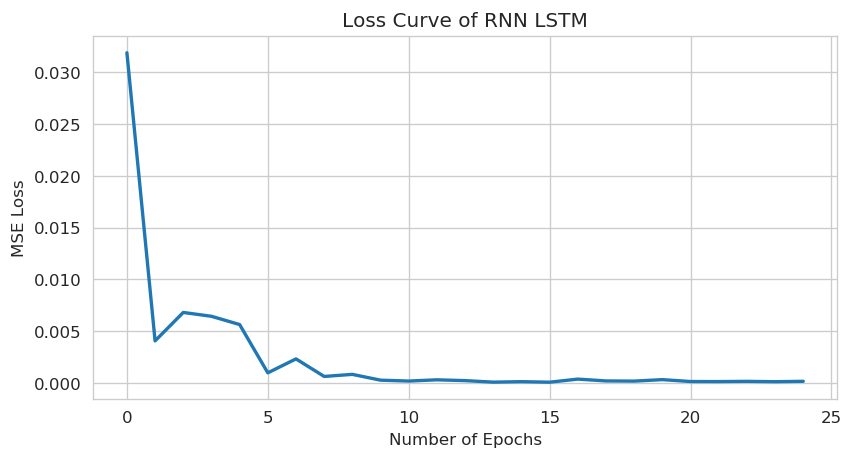

In [26]:
loss_per_epoch = model.history.history['loss']
fig = plt.figure(dpi = 120,figsize = (8,4))
ax = plt.axes()
ax.set(xlabel = 'Number of Epochs',ylabel = 'MSE Loss',title = 'Loss Curve of RNN LSTM')
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,lw = 2);

> We can see how good our model is able to converge !!

## Evaluate on Test Data

This part is little bit trickt to understand. RNN LSTM actually uses past data to predict next one data point. Here our input length is 15, So in each iteration model will use past 15 data to predict next one.

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.head()

,Confirmed,Predictions
ObservationDate,,
2020-04-17,14352.0,15010.666681
2020-04-18,15722.0,16268.330729
2020-04-19,17615.0,17601.734738
2020-04-20,18539.0,18995.345550
2020-04-21,20080.0,20448.445977


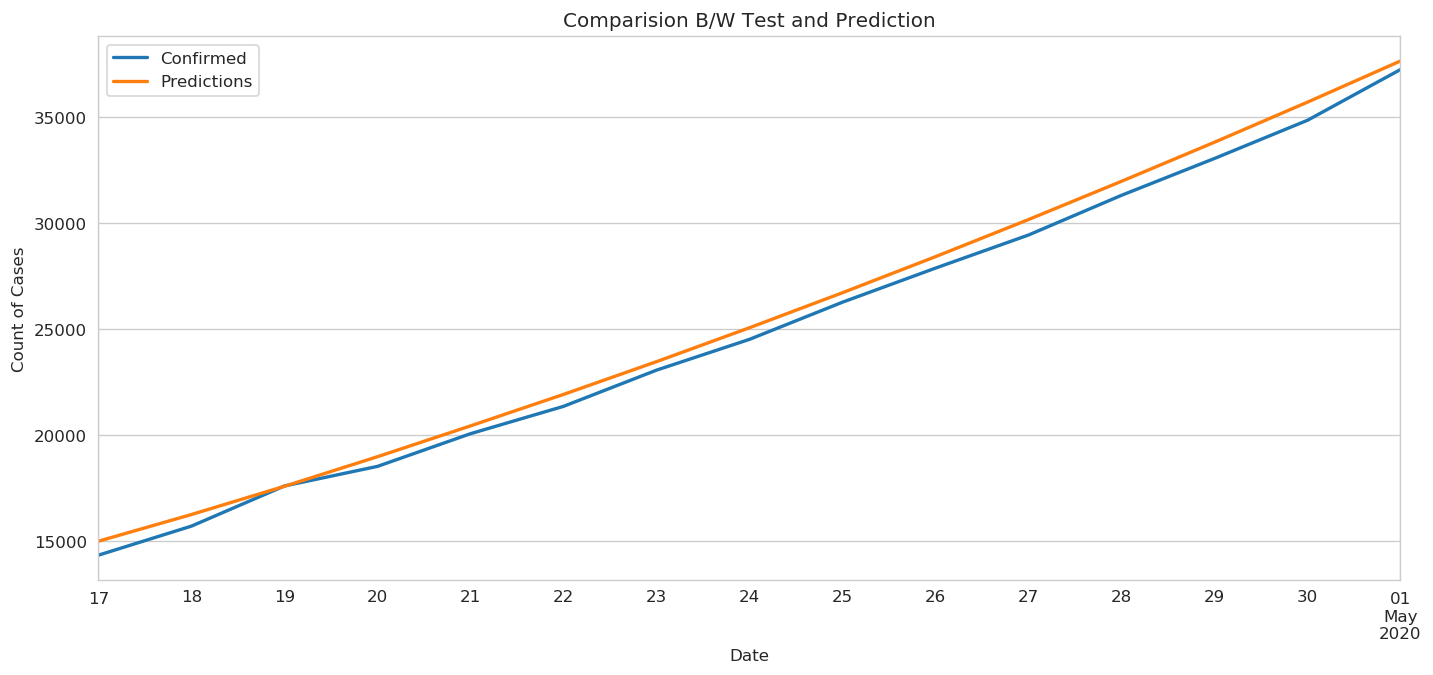

In [29]:
fig = plt.figure(dpi = 120)
ax=plt.axes()
test.plot(legend=True,figsize=(14,6),lw = 2,ax=ax)
plt.xlabel('Date')
plt.ylabel('Count of Cases')
plt.title('Comparision B/W Test and Prediction')
plt.show();

> We can see our model is caapturing trend, But India is beating Corona !! :)

## Forecasting

To forecast, we need to refit model again with whole data points.

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train = pd.DataFrame(covidIndia.iloc[:,1])


scaler.fit(train)
scaled_train = scaler.transform(train)

n_input = 15
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit_generator(generator,epochs=25)

Epoch 1/25
78/78 [==============================] - 1s 14ms/step - loss: 0.0235
Epoch 2/25
78/78 [==============================] - 1s 9ms/step - loss: 0.0138
Epoch 3/25
78/78 [==============================] - 1s 9ms/step - loss: 9.7539e-04
Epoch 4/25
78/78 [==============================] - 1s 9ms/step - loss: 3.7717e-04
Epoch 5/25
78/78 [==============================] - 1s 9ms/step - loss: 1.9408e-04
Epoch 6/25
78/78 [==============================] - 1s 9ms/step - loss: 9.6631e-05
Epoch 7/25
78/78 [==============================] - 1s 9ms/step - loss: 1.0143e-04
Epoch 8/25
78/78 [==============================] - 1s 9ms/step - loss: 8.4388e-05
Epoch 9/25
78/78 [==============================] - 1s 9ms/step - loss: 9.7457e-05
Epoch 10/25
78/78 [==============================] - 1s 9ms/step - loss: 5.1770e-05
Epoch 11/25
78/78 [==============================] - 1s 9ms/step - loss: 1.2168e-04
Epoch 12/25
78/78 [==============================] - 1s 9ms/step - loss: 7.4527e-05
Epoch 13

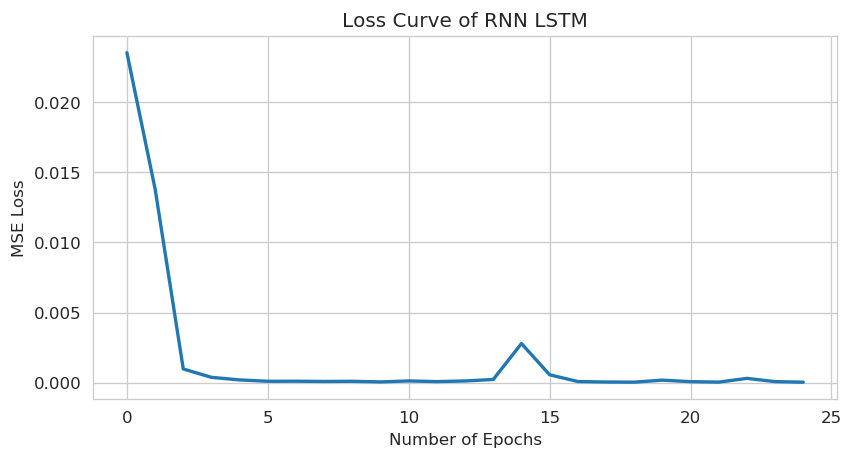

In [31]:
loss_per_epoch = model.history.history['loss']
fig = plt.figure(dpi = 120,figsize = (8,4))
ax = plt.axes()
ax.set(xlabel = 'Number of Epochs',ylabel = 'MSE Loss',title = 'Loss Curve of RNN LSTM')
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,lw = 2);

In [32]:
forecast = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(15):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

forecast= scaler.inverse_transform(forecast)

In [33]:
forecast = pd.DataFrame({'Forecast':forecast.flatten()})
forecast.index = np.arange('2020-05-01',15,dtype='datetime64[D]')
forecast.head()

,Forecast
2020-05-01,40577.962013
2020-05-02,43240.791281
2020-05-03,46119.314844
2020-05-04,49197.295452
2020-05-05,52557.780250


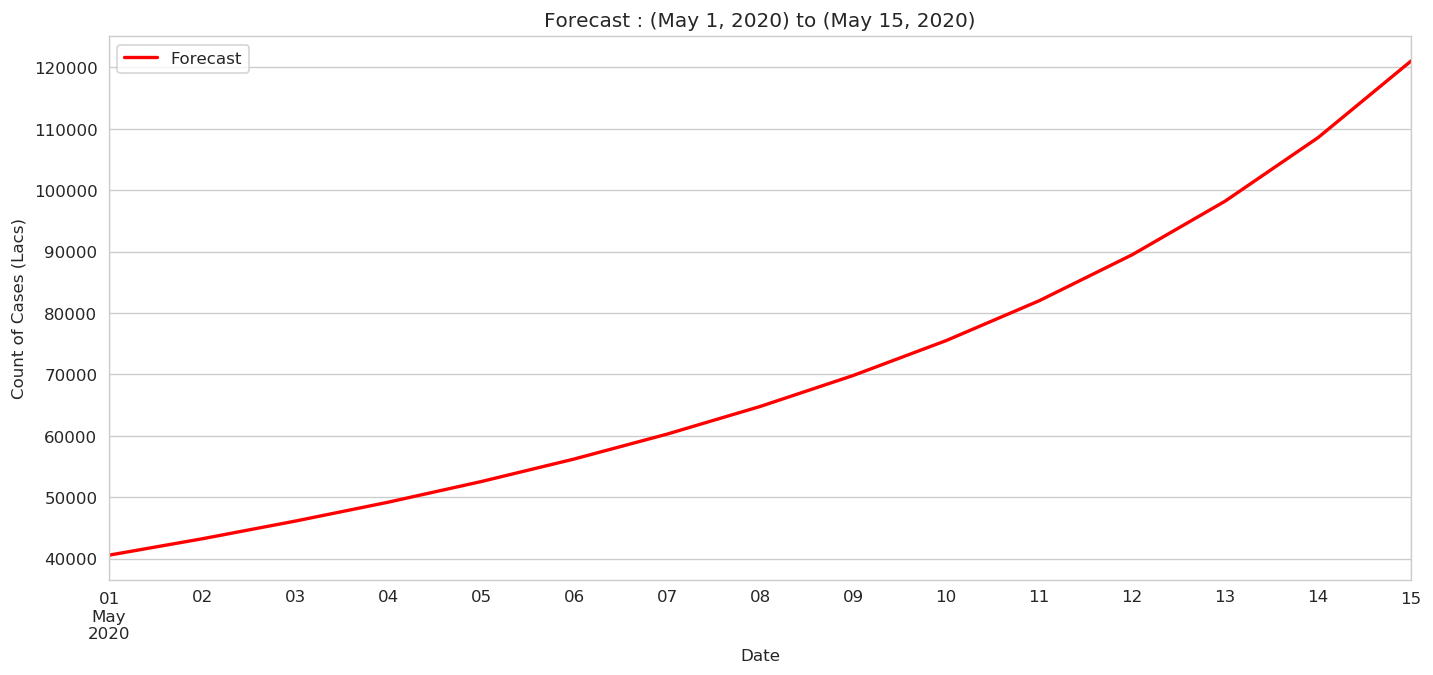

In [34]:
fig = plt.figure(dpi=120,figsize = (14,6))
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Count of Cases (Lacs)',title = 'Forecast : (May 1, 2020) to (May 15, 2020)')
forecast.plot(label = 'Forecast',ax=ax,color='red',lw=2);

> So , Here is forecast for 15 days using RNN.

# Facebook Prophet

![](https://www.kdnuggets.com/wp-content/uploads/prophet-facebook.jpg)

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

## IMPORTANT NOTE ONE:

**You should really read the papaer for Prophet! It is relatively straightforward and has a lot of insight on their techniques on how Prophet works internally!**

Link to paper: https://peerj.com/preprints/3190.pdf

## Preprocessing

Prophet needs a specific format at input. So we need little bit preprocessing here.

In [35]:
df = pd.DataFrame(covidIndia.iloc[:,1])
df.reset_index(inplace = True)
df.head()

,ObservationDate,Confirmed
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0


In [36]:
df.columns = ['ds','y']
df.head()

,ds,y
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0


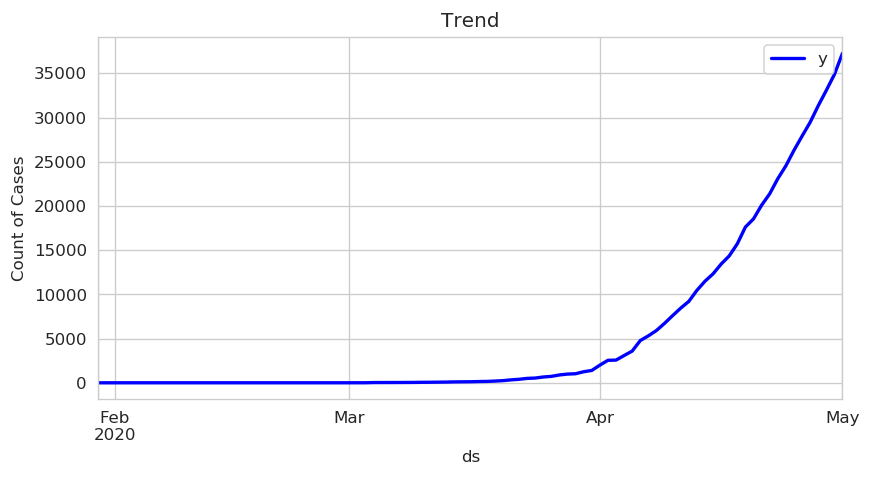

In [42]:
fig = plt.figure(dpi = 120)
axes = plt.axes()
axes.set(xlabel = 'Date',ylabel = 'Count of Cases',title = 'Trend')
df.plot(x='ds',y='y',figsize=(8,4),lw=2,color = 'blue',ax=axes);

## Model Validation

In [43]:
train = df.iloc[:78]
test = df.iloc[78:]

In [44]:
from fbprophet import Prophet
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

In [46]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
88,2020-04-27,20128.268112,19423.589377,20717.205995
89,2020-04-28,20860.019782,20119.822597,21526.489885
90,2020-04-29,21569.771033,20750.505665,22323.130931
91,2020-04-30,22306.493514,21404.245832,23055.213275
92,2020-05-01,22879.966743,21855.007405,23753.147702


In [47]:
test.tail(5)

,ds,y
88,2020-04-27,29451.0
89,2020-04-28,31324.0
90,2020-04-29,33062.0
91,2020-04-30,34863.0
92,2020-05-01,37257.0


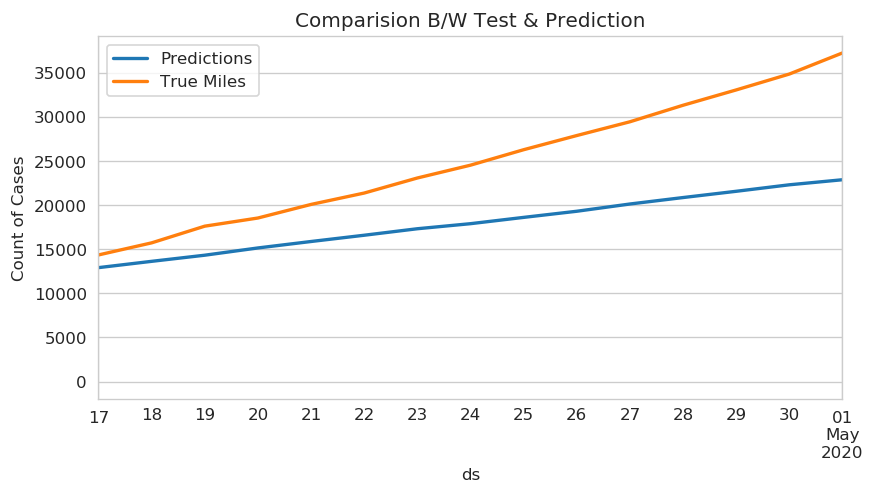

In [54]:
fig = plt.figure(dpi = 120)
ax = plt.axes()
ax.set(xlabel = 'Date',ylabel = 'Count of Cases',title = 'Comparision B/W Test & Prediction')
forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(8,4),ax=ax,lw=2)
test.plot(x='ds',y='y',label='True Miles',legend=True,ax=ax,xlim=('2020-04-17','2020-05-01'),lw=2);

> Well according to Prophet prediction, Number of Cases should have been decreased as compared to real data!! But our model is doing good.

In [56]:
from statsmodels.tools.eval_measures import rmse
predictions = forecast.iloc[-15:]['yhat']
print("RMSE ==> ",rmse(predictions,test['y']))

RMSE ==>  8049.237211798271


In [57]:
print("Test Mean ==> ",test.mean())

Test Mean ==>  y    25027.666667
dtype: float64


## Forecast

Let us forecast for May 1, 2020 to May 15, 2020. Note we have to fit again on whole data...

In [59]:
from fbprophet import Prophet
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)

In [60]:
df.tail()

,ds,y
88,2020-04-27,29451.0
89,2020-04-28,31324.0
90,2020-04-29,33062.0
91,2020-04-30,34863.0
92,2020-05-01,37257.0


In [61]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
103,2020-05-12,50852.152376,49706.821372,51890.859321
104,2020-05-13,52255.262370,50966.932141,53470.647559
105,2020-05-14,53724.744255,52300.128001,55069.489027
106,2020-05-15,55175.646411,53679.191964,56734.782129
107,2020-05-16,56477.163493,54602.010140,58298.845055


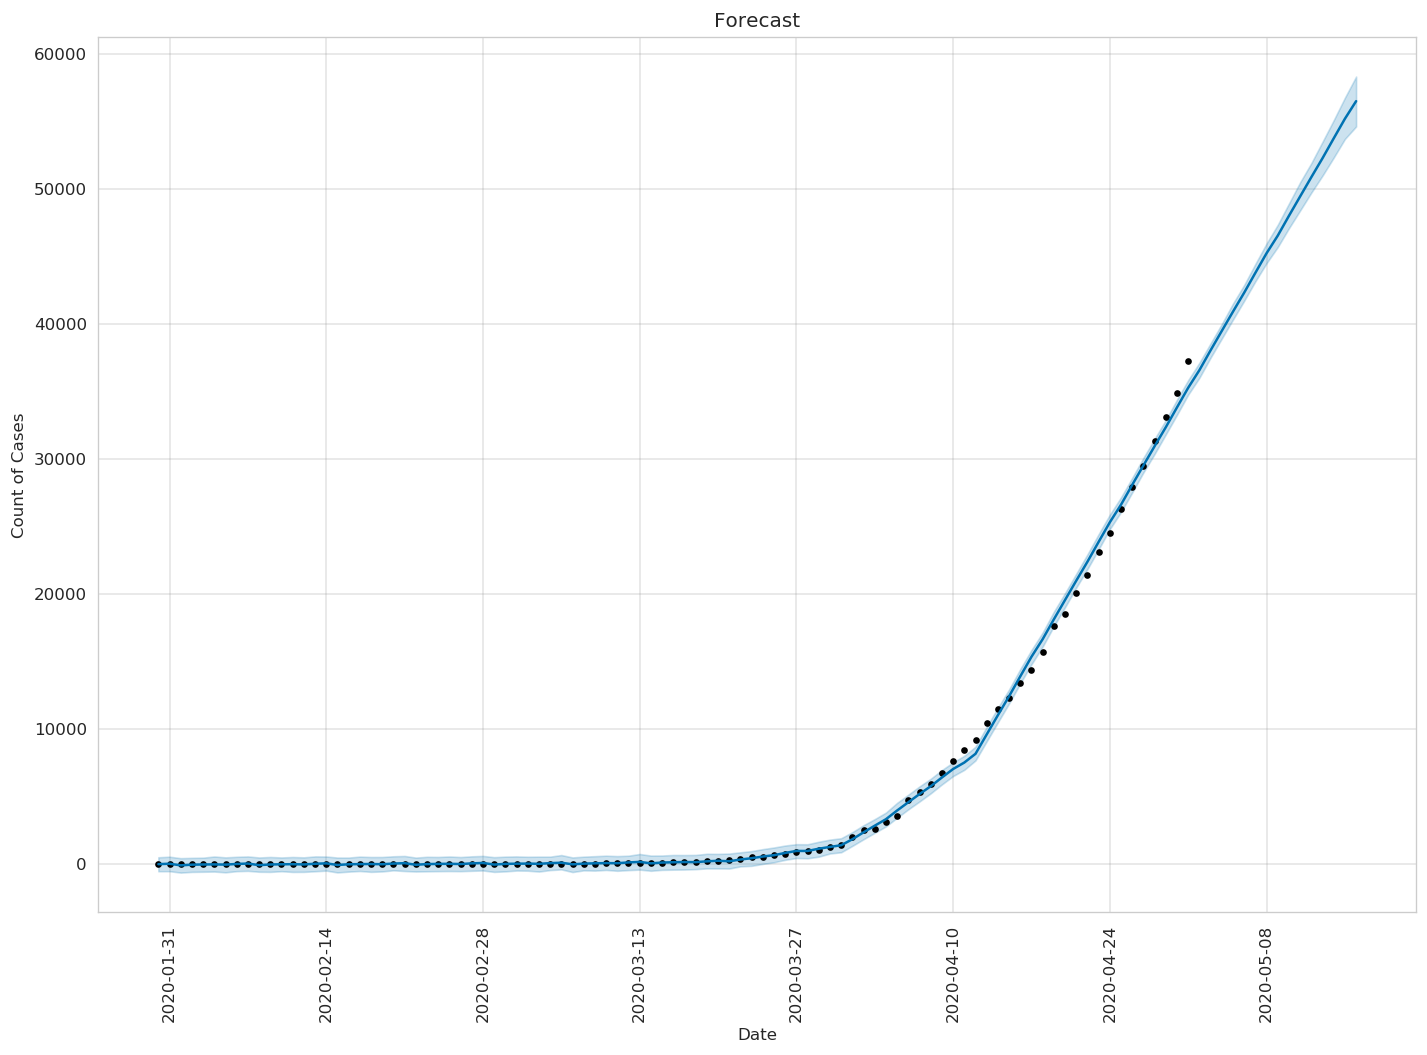

In [92]:
fig = plt.figure(dpi = 120 )
axes = plt.axes()
m.plot(forecast, figsize = (8,4),ax=axes)
plt.xlabel('Date')
plt.ylabel('Count of Cases')
plt.title('Forecast')
plt.xticks(rotation = 90);

### How good Prophet is doing, Just see black dots are actual confirmed cases while line are prediction with uncertainity...

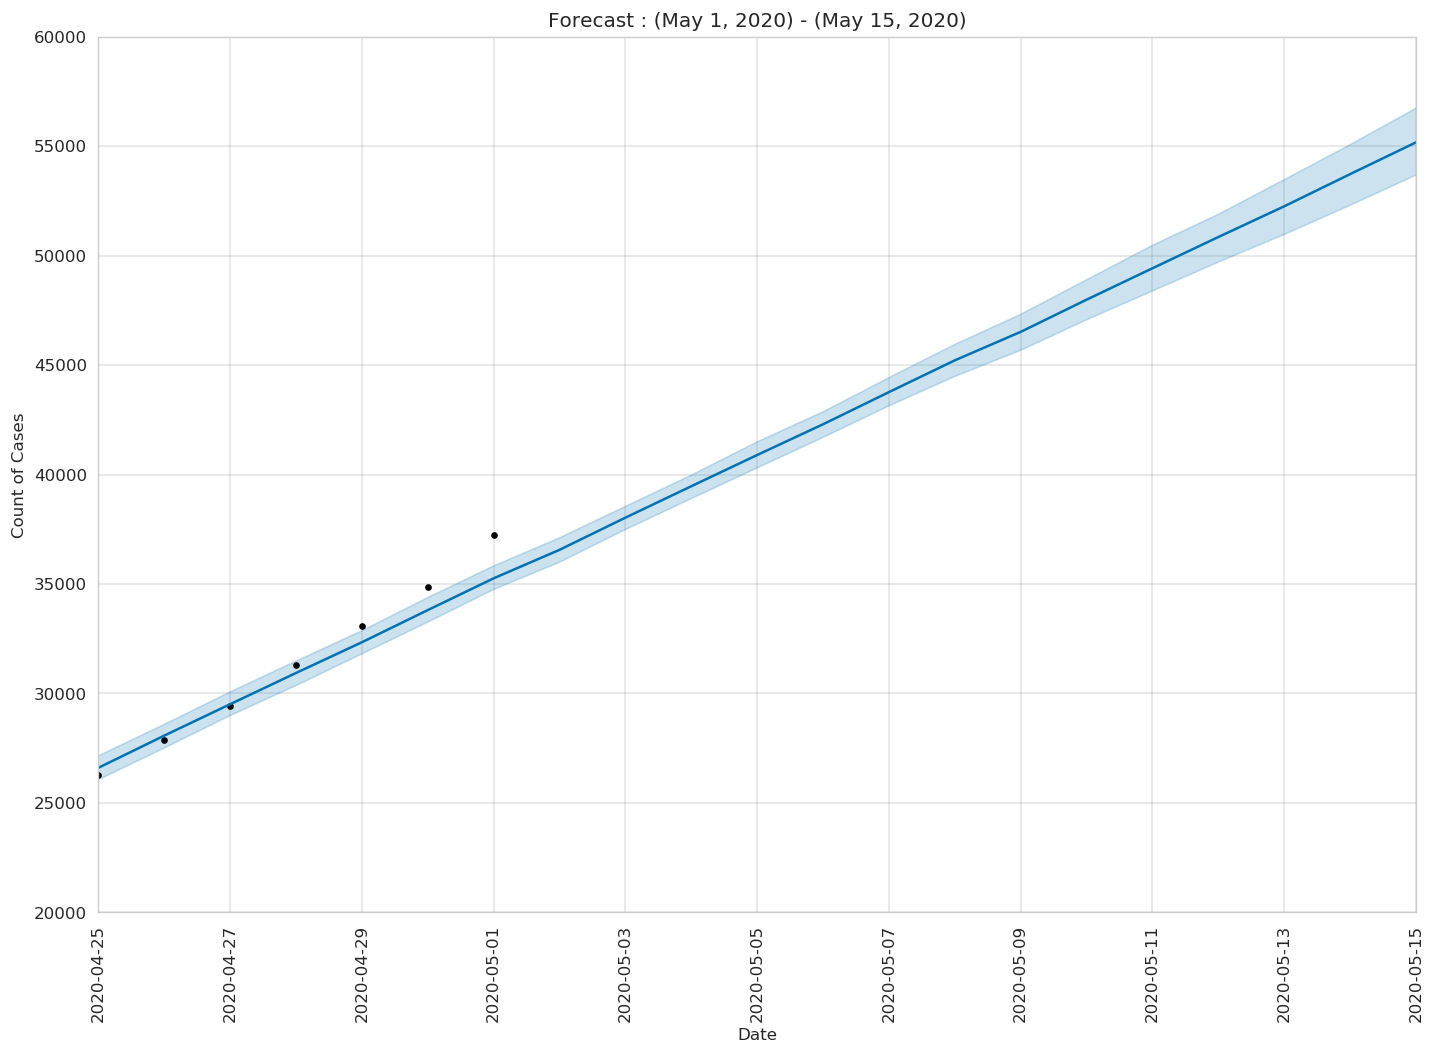

In [84]:
plt.figure(dpi = 120)
axes = plt.axes()
m.plot(forecast,ax=axes,figsize = (8,4))
start = pd.to_datetime(['2020-04-25'])
end = pd.to_datetime(['2020-05-15'])
plt.xlabel('Date')
plt.ylabel('Count of Cases')
plt.title('Forecast : (May 1, 2020) - (May 15, 2020)')
plt.xlim(start,end)
plt.ylim(20000,60000)
plt.xticks(rotation = 90);

### Now we have forecast for May 1, 2020 to May 15, 2020.

## Now i will end up my notebook here , Thank you for reading!! I hope you guys have learned something.

## Please do upvote, if you like !!